In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Attention


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


import warnings
warnings.filterwarnings("ignore")

print(f"TensorFlow Version: {tf.__version__}")


TensorFlow Version: 2.18.0


In [ ]:
import pandas as pd

df = pd.read_csv('Relaince.csv')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1462 non-null   object 
 1   Open       1462 non-null   float64
 2   Close      1462 non-null   float64
 3   High       1462 non-null   float64
 4   Low        1462 non-null   float64
 5   Volume     1462 non-null   int64  
 6   EMA        1462 non-null   float64
 7   RSI        1462 non-null   float64
 8   BB_Middle  1462 non-null   float64
 9   BB_Upper   1462 non-null   float64
 10  BB_Lower   1462 non-null   float64
 11  ADX        1462 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 137.2+ KB


In [ ]:

print("Missing Values Before Handling:\n", df.isnull().sum())


df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
df.fillna(0, inplace=True)

print("\nMissing Values After Handling:\n", df.isnull().sum())


numeric_cols = df.select_dtypes(include=['number'])

Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


df[numeric_cols.columns] = numeric_cols.clip(lower=lower_bound, upper=upper_bound, axis=1)

print("\nOutliers handled successfully!")


Missing Values Before Handling:
 Date         0
Open         0
Close        0
High         0
Low          0
Volume       0
EMA          0
RSI          0
BB_Middle    0
BB_Upper     0
BB_Lower     0
ADX          0
dtype: int64

Missing Values After Handling:
 Date         0
Open         0
Close        0
High         0
Low          0
Volume       0
EMA          0
RSI          0
BB_Middle    0
BB_Upper     0
BB_Lower     0
ADX          0
dtype: int64

Outliers handled successfully!


In [ ]:



target_column = 'Close'


features = df.select_dtypes(include=['number']).drop(columns=[target_column])

target = df[target_column]

print("Selected Features:\n", features.columns)
print("\nTarget Variable:", target_column)


Selected Features:
 Index(['Open', 'High', 'Low', 'Volume', 'EMA', 'RSI', 'BB_Middle', 'BB_Upper',
       'BB_Lower', 'ADX'],
      dtype='object')

Target Variable: Close


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


features_scaled = scaler.fit_transform(features)

features_scaled = pd.DataFrame(features_scaled, columns=features.columns)


target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

print("Features after MinMax Scaling:\n", features_scaled.head())
print("\nTarget after MinMax Scaling:\n", target_scaled[:5])


Features after MinMax Scaling:
        Open      High       Low    Volume       EMA       RSI  BB_Middle  \
0  0.091570  0.084679  0.103228  0.574257  0.003607  0.719680   0.018504   
1  0.092542  0.080493  0.098068  0.276783  0.005176  0.729593   0.020563   
2  0.086226  0.074119  0.095713  0.255012  0.006430  0.670241   0.022153   
3  0.080901  0.074421  0.094628  0.291232  0.007679  0.683397   0.023486   
4  0.082863  0.070725  0.086757  0.293918  0.007549  0.570013   0.023887   

   BB_Upper  BB_Lower       ADX  
0  0.013003  0.094678  0.096829  
1  0.013674  0.097958  0.098864  
2  0.014461  0.100218  0.082631  
3  0.015642  0.101581  0.075390  
4  0.015679  0.102317  0.088878  

Target after MinMax Scaling:
 [[0.10102719]
 [0.09691687]
 [0.09538009]
 [0.09643538]
 [0.08477088]]


In [ ]:
import numpy as np

sequence_length = 60


X, y = [], []

for i in range(len(features_scaled) - sequence_length):
    X.append(features_scaled.iloc[i : i + sequence_length].values) 'sequence_length' time steps
    y.append(target_scaled[i + sequence_length])

X, y = np.array(X), np.array(y)

print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")


Shape of X (features): (1402, 60, 10)
Shape of y (target): (1402, 1)


In [ ]:

train_size = int(0.8 * len(X))


X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training Data Shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing Data Shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training Data Shape: X_train: (1121, 60, 10), y_train: (1121, 1)
Testing Data Shape: X_test: (281, 60, 10), y_test: (281, 1)


model build

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, RepeatVector, Concatenate


latent_dim = 64
timesteps = X_train.shape[1]
features = X_train.shape[2]


encoder_inputs = Input(shape=(timesteps, features))
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)


attention = Attention()
attention_output = attention([encoder_outputs, encoder_outputs])


decoder_inputs = RepeatVector(timesteps)(state_h)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=False)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])


concat_outputs = Concatenate()([decoder_outputs, attention_output])


final_output = Dense(1)(concat_outputs[:, -1, :])



model = Model(inputs=encoder_inputs, outputs=final_output)


model.compile(optimizer='adam', loss='mse', metrics=['mae'])


model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 60, 64),  │     19,200 │ input_layer[0][0] │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 60, 64)    │          0 │ lstm[0][1]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 60, 64)    │     33,024 │ repeat_vector[0]… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 60, 64)    │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 128)   │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ get_item[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,353 (204.50 KB)

 Trainable params: 52,353 (204.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K


y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


def rmse(y_true, y_pred):
    y_pred = K.squeeze(y_pred, axis=-1)
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', rmse]
)


model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 60, 64),  │     19,200 │ input_layer[0][0] │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 60, 64)    │          0 │ lstm[0][1]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 60, 64)    │     33,024 │ repeat_vector[0]… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 60, 64)    │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 128)   │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ get_item[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,353 (204.50 KB)

 Trainable params: 52,353 (204.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


batch_size = 32
epochs = 100


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)


model_checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0461 - mae: 0.1578 - rmse: 0.3059
Epoch 1: val_loss improved from inf to 0.01740, saving model to best_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0446 - mae: 0.1543 - rmse: 0.3040 - val_loss: 0.0174 - val_mae: 0.1239 - val_rmse: 0.1283 - learning_rate: 0.0010
Epoch 2/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0019 - mae: 0.0344 - rmse: 0.2619
Epoch 2: val_loss improved from 0.01740 to 0.00601, saving model to best_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0019 - mae: 0.0343 - rmse: 0.2617 - val_loss: 0.0060 - val_mae: 0.0690 - val_rmse: 0.0778 - learning_rate: 0.0010
Epoch 3/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0012 - mae: 0.0273 - rmse: 0.2621
Epoch 3: val_loss improved from 0.00601 to 0.00573, saving model to best_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0011 - mae: 0.0272 - rmse: 0.2619 - val_loss: 0.0057 - val_mae: 0.0684 - val_rmse: 0.0779 - learning_rate: 0.0010
Epoch 4/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.6904e-04 - mae: 0.0228 - rmse: 0.2636
Epoch 4: val_loss improved from 0.00573 to 0.00449, saving model to best_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.6565e-04 - mae: 0.0227 - rmse: 0.2634 - val_loss: 0.0045 - val_mae: 0.0600 - val_rmse: 0.0714 - learning_rate: 0.0010
Epoch 5/100
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.3627e-04 - mae: 0.0203 - rmse: 0.2717
Epoch 5: val_loss improved from 0.00449 to 0.00443, saving model to best_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.3926e-04 - mae: 0.0203 - rmse: 0.2710 - val_loss: 0.0044 - val_mae: 0.0597 - val_rmse: 0.0714 - learning_rate: 0.0010
Epoch 6/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5268e-04 - mae: 0.0196 - rmse: 0.2668
Epoch 6: val_loss improved from 0.00443 to 0.00189, saving model to best_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.4944e-04 - mae: 0.0195 - rmse: 0.2665 - val_loss: 0.0019 - val_mae: 0.0358 - val_rmse: 0.0532 - learning_rate: 0.0010
Epoch 7/100
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.6838e-04 - mae: 0.0186 - rmse: 0.2739
Epoch 7: val_loss improved from 0.00189 to 0.00182, saving model to best_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 5.6587e-04 - mae: 0.0185 - rmse: 0.2730 - val_loss: 0.0018 - val_mae: 0.0349 - val_rmse: 0.0534 - learning_rate: 0.0010
Epoch 8/100
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.0480e-04 - mae: 0.0177 - rmse: 0.2663
Epoch 8: val_loss improved from 0.00182 to 0.00173, saving model to best_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.0209e-04 - mae: 0.0176 - rmse: 0.2660 - val_loss: 0.0017 - val_mae: 0.0342 - val_rmse: 0.0530 - learning_rate: 0.0010
Epoch 9/100
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.6573e-04 - mae: 0.0166 - rmse: 0.2644
Epoch 9: val_loss improved from 0.00173 to 0.00117, saving model to best_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.6915e-04 - mae: 0.0167 - rmse: 0.2643 - val_loss: 0.0012 - val_mae: 0.0273 - val_rmse: 0.0475 - learning_rate: 0.0010
Epoch 10/100
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.0575e-04 - mae: 0.0174 - rmse: 0.2703
Epoch 10: val_loss improved from 0.00117 to 0.00104, saving model to best_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.0213e-04 - mae: 0.0174 - rmse: 0.2699 - val_loss: 0.0010 - val_mae: 0.0256 - val_rmse: 0.0463 - learning_rate: 0.0010
Epoch 11/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.7359e-04 - mae: 0.0169 - rmse: 0.2726
Epoch 11: val_loss did not improve from 0.00104
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.7204e-04 - mae: 0.0169 - rmse: 0.2721 - val_loss: 0.0044 - val_mae: 0.0600 - val_rmse: 0.0730 - learning_rate: 0.0010
Epoch 12/100
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.5147e-04 - mae: 0.0217 - rmse: 0.2704
Epoch 12: val_loss did not improve from 0.00104
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.4311e-04 - mae: 0.0216 - rmse: 0.2698 - val_loss: 0.0014 - val_mae: 0.0304 - val_rmse: 0.0500 - learning_rate: 0.0010
Epoch 13/100
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.0810e-04 - mae: 0.0178 - rmse: 0.2667
Epoch 13: val_loss did not improve from 0.00104
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 5.2602e-04 - mae: 0.0174 - rmse: 0.2685 - val_loss: 7.0586e-04 - val_mae: 0.0212 - val_rmse: 0.0435 - learning_rate: 5.0000e-04
Epoch 17/100
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.1147e-04 - mae: 0.0158 - rmse: 0.2771
Epoch 17: val_loss did not improve from 0.00071
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.1007e-04 - mae: 0.0158 - rmse: 0.2761 - val_loss: 7.8524e-04 - val_mae: 0.0221 - val_rmse: 0.0443 - learning_rate: 5.0000e-04
Epoch 18/100
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.5331e-04 - mae: 0.0146 - rmse: 0.2748
Epoch 18: val_loss did not improve from 0.00071
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.5511e-04 - mae: 0.0146 - rmse: 0.2739 - val_loss: 7.7991e-04 - val_mae: 0.0220 - val_rmse: 0.0441 - learning_rate: 5.0000e-04
Epoch 19/100
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.7956e-04 - mae: 0.0148 - rmse: 0.2689
Epoch 19: val_loss did not improve from 0.00071
36/36 ━━━━━━━━━━━━━━━━━━━

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 3.4991e-04 - mae: 0.0144 - rmse: 0.2688 - val_loss: 6.5540e-04 - val_mae: 0.0203 - val_rmse: 0.0431 - learning_rate: 1.2500e-04
Epoch 30/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.8528e-04 - mae: 0.0151 - rmse: 0.2711
Epoch 30: val_loss did not improve from 0.00066
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.8255e-04 - mae: 0.0150 - rmse: 0.2707 - val_loss: 9.2964e-04 - val_mae: 0.0243 - val_rmse: 0.0464 - learning_rate: 1.2500e-04
Epoch 31/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.1800e-04 - mae: 0.0137 - rmse: 0.2646
Epoch 31: val_loss did not improve from 0.00066

Epoch 31: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.1859e-04 - mae: 0.0137 - rmse: 0.2645 - val_loss: 0.0010 - val_mae: 0.0261 - val_rmse: 0.0476 - learning_rate: 1.2500e-04
Epoch 32/100
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.1104e-04 - mae: 0.0134 - rmse: 0.2651


metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


y_pred = model.predict(X_test)


y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
Percentage Error (MAPE)


direction_true = np.sign(np.diff(y_test, axis=0))
direction_pred = np.sign(np.diff(y_pred, axis=0))
direction_accuracy = np.mean(direction_true == direction_pred) * 100


print(f"📌 Mean Squared Error (MSE): {mse:.6f}")
print(f"📌 Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"📌 Mean Absolute Error (MAE): {mae:.6f}")
print(f"📌 Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"📌 Directional Accuracy: {direction_accuracy:.2f}%")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
📌 Mean Squared Error (MSE): 0.000655
📌 Root Mean Squared Error (RMSE): 0.025601
📌 Mean Absolute Error (MAE): 0.020305
📌 Mean Absolute Percentage Error (MAPE): 2.38%
📌 Directional Accuracy: 44.64%


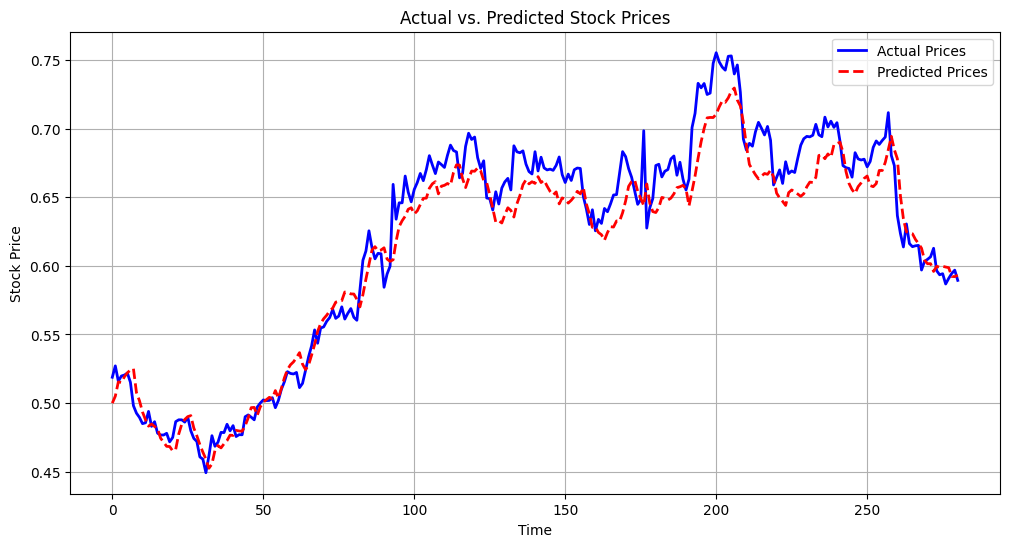

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 🚀 Ensure scaler_y is fitted on training target data
scaler_y = MinMaxScaler()
scaler_y.fit(y_train)  # ✅ Fit the scaler on y_train before inverse transforming

# 🔄 Convert predictions back to the original price scale
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

# 📈 Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual Prices', color='blue', linewidth=2)
plt.plot(y_pred_original, label='Predicted Prices', color='red', linestyle='dashed', linewidth=2)

# 📌 Labels & Legends
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.grid(True)

# 🔍 Show the plot
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler


scaler_target = MinMaxScaler()


scaler_target.fit(y_train.reshape(-1, 1))


MinMaxScaler()

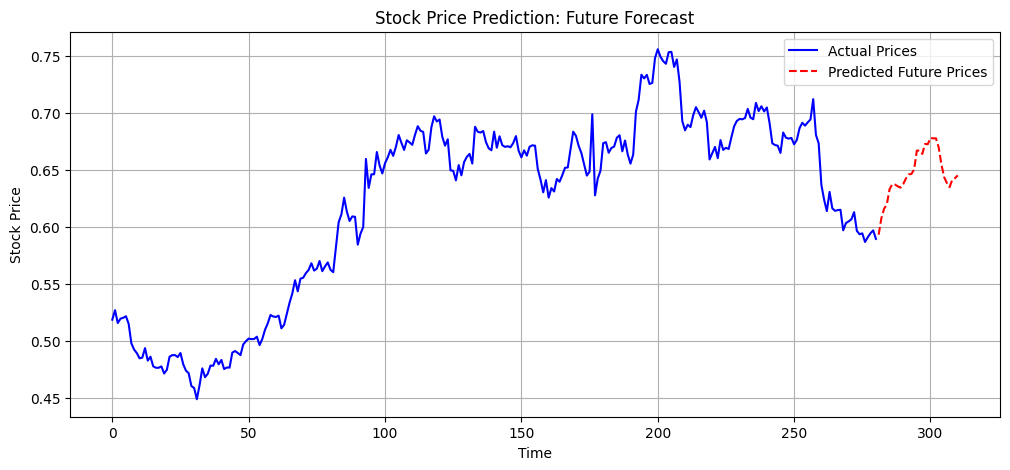

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


future_steps = 30

future_input = X_test[-1]

future_input = np.expand_dims(future_input, axis=0)


future_predictions = []


for _ in range(future_steps):

    predicted_value = model.predict(future_input, verbose=0)


    future_predictions.append(predicted_value[0, 0])


    future_input = np.roll(future_input, shift=-1, axis=1)
    future_input[0, -1, -1] = predicted_value


future_predictions = scaler_target.inverse_transform(np.array(future_predictions).reshape(-1, 1))

plt.figure(figsize=(12, 5))
plt.plot(range(len(y_test)), scaler_target.inverse_transform(y_test), label="Actual Prices", color='blue')
plt.plot(range(len(y_test), len(y_test) + future_steps), future_predictions, label="Predicted Future Prices", color='red', linestyle='dashed')

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Future Forecast")
plt.legend()
plt.grid()
plt.show()


In [ ]:

scaler_target = MinMaxScaler()
scaler_target.fit(target.values.reshape(-1, 1))


MinMaxScaler()

In [ ]:

y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler_target.inverse_transform(y_pred.reshape(-1, 1))


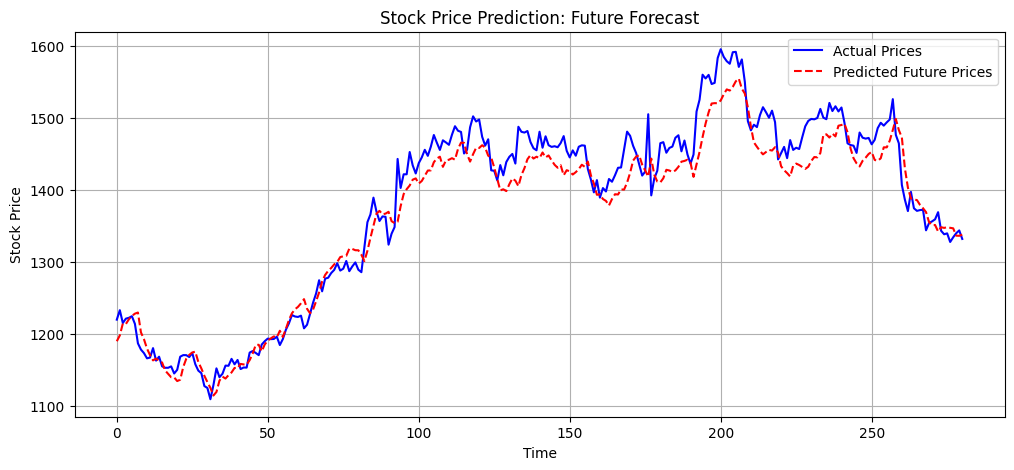

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test_original, label="Actual Prices", color='blue')
plt.plot(y_pred_original, label="Predicted Future Prices", color='red', linestyle='dashed')

plt.title("Stock Price Prediction: Future Forecast")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()

plt.show()


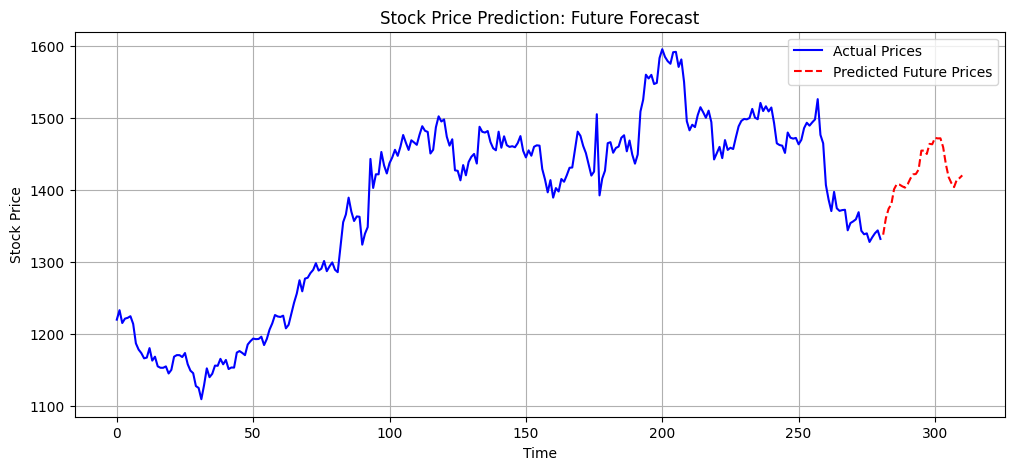

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


future_steps = 30


future_input = X_test[-1]


future_input = np.expand_dims(future_input, axis=0)


future_predictions = []


for _ in range(future_steps):

    predicted_value = model.predict(future_input, verbose=0)


    future_predictions.append(predicted_value[0, 0])

    future_input = np.roll(future_input, shift=-1, axis=1)
    future_input[0, -1, -1] = predicted_value[0, 0]


future_predictions = scaler_target.inverse_transform(np.array(future_predictions).reshape(-1, 1))



y_test_original = scaler_target.inverse_transform(y_test)


plt.figure(figsize=(12, 5))


plt.plot(range(len(y_test_original)), y_test_original, label="Actual Prices", color='blue')


plt.plot(range(len(y_test_original), len(y_test_original) + future_steps),
         future_predictions, label="Predicted Future Prices", color='red', linestyle='dashed')

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Future Forecast")
plt.legend()
plt.grid()
plt.show()
